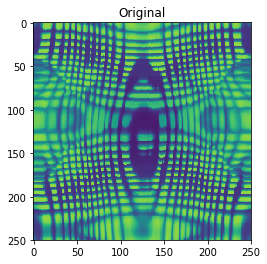

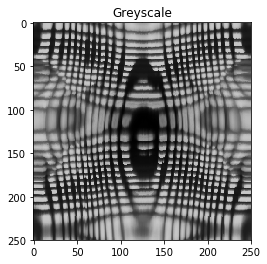

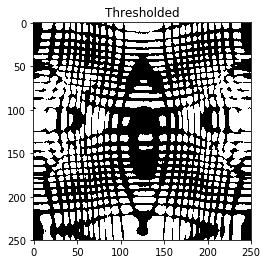

In [66]:
# Libraries
import numpy    as     np
import imageio
from   scipy      import misc
from   scipy      import signal
from skimage import data
from skimage.color import rgb2gray

from   matplotlib import cm
from   matplotlib import pyplot

# Imports "Modern Art" image in which to detect axis of symmetry in x and y

originalImage  = imageio.imread('Target.bmp')
pyplot.imshow(originalImage)
pyplot.title('Original')
pyplot.show()

grayScaleImage = rgb2gray(originalImage)
pyplot.imshow(grayScaleImage, cmap= pyplot.cm.gray)
pyplot.title('Greyscale')
pyplot.show()

# Apply threshold
threshold = np.sum(grayScaleImage) / np.size(grayScaleImage)

thresholdedImage = (grayScaleImage[:, :] > threshold) * 255
pyplot.imshow(thresholdedImage, cmap= pyplot.cm.gray)
pyplot.title('Thresholded')
pyplot.show()

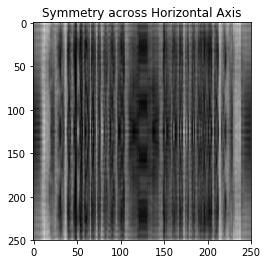

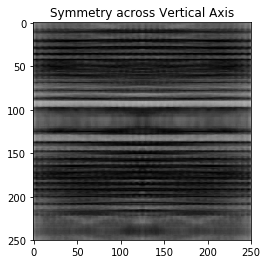

In [80]:
# Finds correlation of image with reversed version along each
# axis for symmetry detection

imageSize = np.shape(grayScaleImage) # Exports as (height, width, depth)

# Reverses image along horizonal axis and runs correlation through every column
verticalCorrelations = np.zeros((imageSize[0], imageSize[1]));
for horizontalIndex in range(imageSize[1]):
    targetColumn  = thresholdedImage[:, horizontalIndex]
    patternColumn = targetColumn #np.flipud(targetColumn)
    # Pads targetRow to emulate wraparound
    targetColumn  = np.concatenate((targetColumn, targetColumn, targetColumn), axis = 0)
    # Preforms correlation
    correlationColumn = np.correlate(targetColumn, patternColumn, mode = 'same')
    verticalCorrelations[:, horizontalIndex] = correlationColumn[(int(imageSize[0] * 1.5)):(int(imageSize[0] * 2.5))]

pyplot.imshow(verticalCorrelations, cmap = pyplot.cm.gray)
pyplot.title('Symmetry across Horizontal Axis')
pyplot.show()

# Reverses image along vertical axis and runs correlation through every row
horizontalCorrelations = np.zeros((imageSize[0], imageSize[1]))
for verticalIndex in range(imageSize[0]):
    targetRow = thresholdedImage[verticalIndex, :]
    patternRow = targetRow #np.flipud(targetRow)
    # Pads for wraparound
    targetRow = np.concatenate((targetRow, targetRow, targetRow), axis = 0)
    # Preforms correlation
    correlationRow = np.correlate(targetRow, patternRow, mode = 'same')
    horizontalCorrelations[verticalIndex, :] = correlationRow[(int(imageSize[1] * 1.5)):(int(imageSize[1] * 2.5))]
    
pyplot.imshow(horizontalCorrelations, cmap = pyplot.cm.gray)
pyplot.title('Symmetry across Vertical Axis')
pyplot.show()